## Data Analysis

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm
import numpy as np
from datetime import datetime
from data import get_data, extract_date_data
from utils import get_path, load_model_data, month, day_of_week, precip_type
plt.style.use('ggplot')

In [2]:
X, y = get_data(include_date = True)
df = X.copy()
X.drop(columns = ['date'], inplace = True)
df['total'] = y.copy()
df.head()

,date,month,day_of_month,day_of_week,precip_intensity_max,precip_intensity_avg,precip_type,wind_speed_max,wind_speed_avg,gust_max,gust_avg,temp_min,temp_max,temp_avg,temp_day,temp_night,humidity,total
0,2018-02-03,2,3,6,0.1336,0.019,1,3.27,3.25,10.24,4.03,0.18,2.84,1.58,2.84,-3.10,0.83,45
1,2018-02-24,2,24,6,0.0000,0.000,0,8.92,8.92,12.12,8.92,-9.05,-0.76,-5.33,-0.76,-9.69,0.60,34
2,2018-03-03,3,3,6,0.1913,0.014,2,5.05,5.08,11.21,5.79,-7.17,0.50,-3.55,0.50,-2.01,0.86,45
3,2018-02-05,2,5,1,0.0000,0.000,0,7.72,7.74,9.97,7.84,-4.58,-1.02,-2.71,-1.02,-5.55,0.74,47
4,2018-03-05,3,5,1,0.0000,0.000,0,4.75,4.76,6.02,4.81,-1.14,6.35,2.27,6.35,1.42,0.87,42


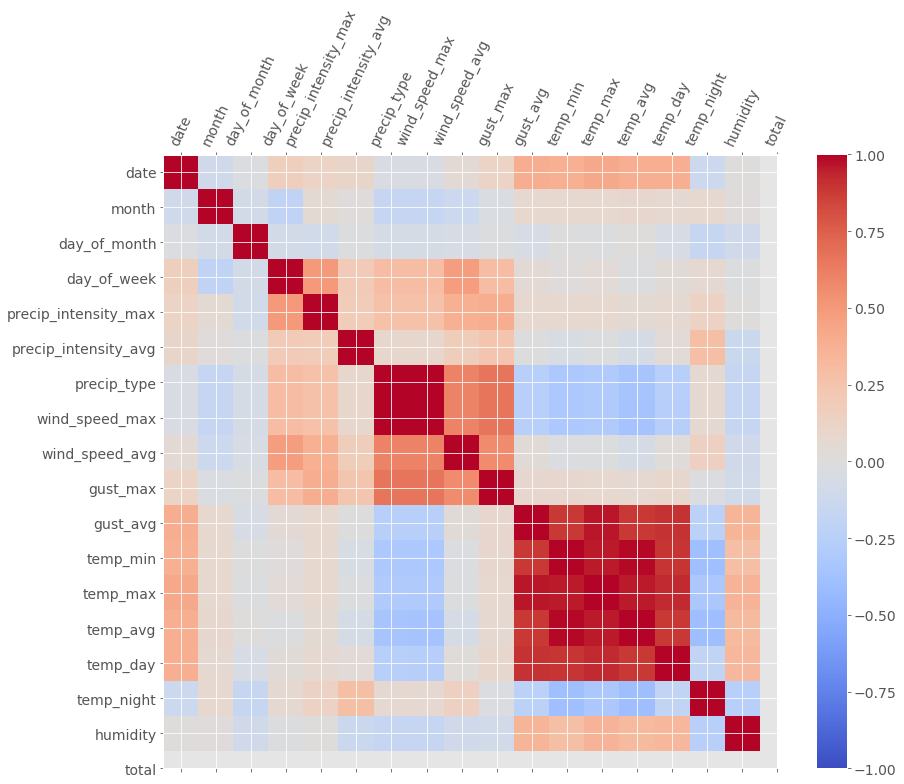

In [3]:
f = plt.figure(figsize = (14, 11))
plt.matshow(df.corr(), fignum = f.number, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=65)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

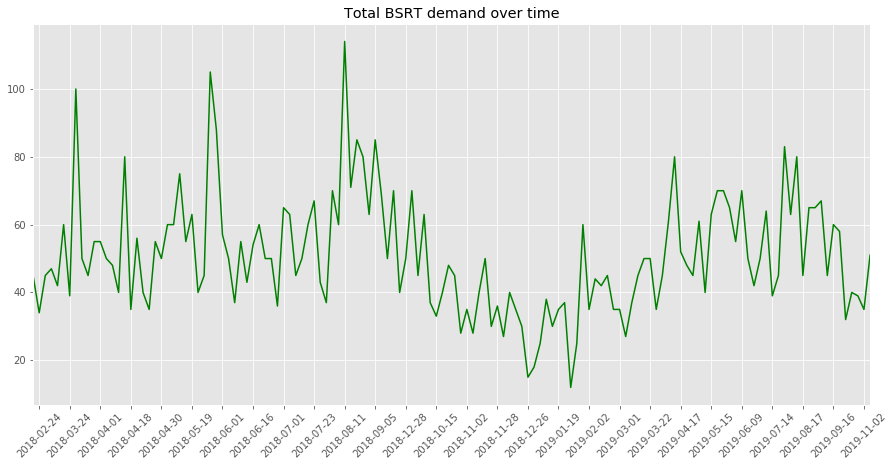

In [21]:
xticks = list(range(1, len(df.index), 5))
ax = df.total.plot(figsize = (15, 7), title = 'Total BSRT demand over time', 
                   rot = 45, xticks = xticks, color = 'g')
ax.set_xticklabels(df.date[xticks])
plt.show()

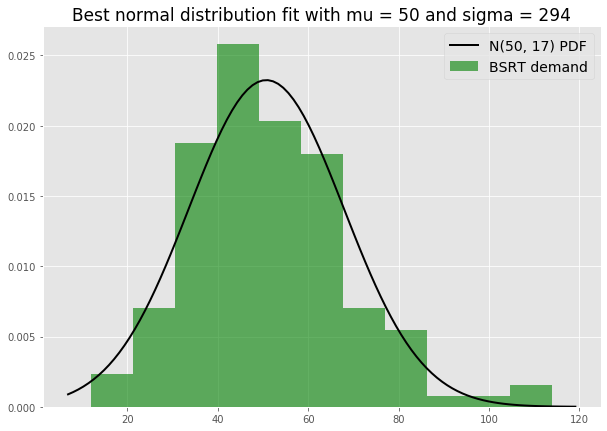

In [28]:
plt.figure(figsize = (10,7))

# Plot the histogram.
plt.hist(df['total'], bins=11, density=True, alpha=0.6, color='g', label = 'BSRT demand')

# Plot the PDF.
xmin, xmax = plt.xlim()
xs = np.linspace(xmin, xmax, 100)
mu, sigma = norm.fit(df['total'])
pdf = norm.pdf(xs, mu, sigma)
plt.plot(xs, pdf, color = 'k', linewidth = 2, label = f'N({int(mu)}, {int(sigma)}) PDF')

plt.title(f'Best normal distribution fit with mu = {int(mu)} and sigma = {int(sigma ** 2)}', fontsize = 17)
plt.legend(fontsize = 14)
plt.show()

## Using the model to impute data

In [ ]:
weather_df = pd.read_csv(get_path('data') / 'weather_data.tsv', sep = '\t')
weather_df.head()

In [ ]:
dates = weather_df['date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))
date_df = extract_date_data(dates)
date_df.head()

In [ ]:
pred_df = pd.concat([date_df, weather_df], axis = 1)
pred_df.head()

In [ ]:
pred_df['month'] = pred_df['month'].map(month)
pred_df['day_of_week'] = pred_df['day_of_week'].map(day_of_week)
pred_df['precip_type'] = pred_df['precip_type'].map(precip_type)
pred_df.head()

In [ ]:
model = load_model_data()['model']
model

In [ ]:
preds = model.predict(pred_df.drop(columns = ['date']), percentiles = [5, 25, 75, 95])
pred_df['bottom_pred'] = preds[:, 0]
pred_df['lower_pred'] = preds[:, 1]
pred_df['upper_pred'] = preds[:, 2]
pred_df['top_pred'] = preds[:, 3]
pred_df.head()

In [ ]:
proj_preds = pred_df[pred_df.date.isin(df.date)]
below_top = df.total.values <= proj_preds.top_pred.values
above_bot = df.total.values >= proj_preds.bottom_pred.values
accuracy = sum(below_top & above_bot) / len(df)

err_df = proj_preds.copy()
err_df['total'] = df.total.values
above_top = err_df[~below_top]
above_err = (above_top.total - above_top.top_pred).mean()
below_bot = err_df[~above_bot]
below_err = (below_bot.bottom_pred - below_bot.total).mean()
off_value = round((above_err + below_err) / 2, 2)

interval_size = (proj_preds.top_pred.values - proj_preds.bottom_pred.values).mean()

print(f'{round(accuracy * 100, 2)}% of the demand was within the 90% confidence interval.')
print(f'The values outside the interval were on average {off_value} off.')
print(f'The average length of the 90% confidence interval is {round(interval_size, 2)}.')

In [ ]:
fig, ax = plt.subplots(figsize = (40, 13))
plt.fill_between(pred_df.date, pred_df.bottom_pred, pred_df.top_pred, 
                 figure = fig, color = 'purple', alpha = 0.15,
                 label = '90% confidence')
plt.fill_between(pred_df.date, pred_df.lower_pred, pred_df.upper_pred, 
                 figure = fig, color = 'purple', alpha = 0.4,
                 label = '50% confidence')
plt.scatter(df.date, df.total, color = 'green', label = 'True values')
plt.xticks(range(1, len(pred_df.index), 25), 
           pred_df.date[list(range(1, len(pred_df.index), 25))], 
           rotation = 45)
plt.legend(fontsize = 17)
plt.title(f'Imputing total demand with {type(model).__name__}', fontsize = 30)
plt.show()

## Visualising model performance

In [ ]:
def earlier_than(date1: str, date2: str):
    from datetime import datetime
    date1, date2 = datetime.strptime(date1, '%Y-%m-%d'), datetime.strptime(date2, '%Y-%m-%d')
    return date1 < date2

In [ ]:
def viz_model(cutoff_date = '2019-09-01'):
    train_idxs = [idx for idx, date in zip(df.index, df.date) if earlier_than(date, cutoff_date)]
    
    X_train, X_val = X.iloc[train_idxs, :], X.iloc[list(set(df.index) - set(train_idxs)), :]
    y_train, y_val = y[train_idxs], y[list(set(df.index) - set(train_idxs))]
    idxs = sorted(X_val.index)

    model = load_model_data()['model'].fit(X_train, y_train)
    preds = model.predict(X_val, percentiles = [5, 25, 75, 95])
    
    fig, ax = plt.subplots(figsize = (15, 7))
    plt.plot(df.date[idxs], df.total[idxs], label = 'True values', color = 'grey')
    plt.fill_between(df.date[idxs], preds[:, 0], preds[:, 3], 
                 figure = fig, color = 'purple', alpha = 0.15, label = '90% confidence')
    plt.fill_between(df.date[idxs], preds[:, 1], preds[:, 2], 
                     figure = fig, color = 'purple', alpha = 0.4, label = '50% confidence')
    plt.legend(fontsize = 17)
    plt.xticks(rotation = 60)
    plt.title(f'Predictions - {type(model).__name__}', fontsize = 18)  
    
    plt.show()

In [ ]:
viz_model(cutoff_date = '2019-09-01')